In [1]:
import torch, os, random
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import gc

In [2]:
selected_class = "aeroplane"
pascal_voc_path = os.path.join(os.getcwd(), "data", "pascal_voc")
train_path = os.path.join(pascal_voc_path, "train")
val_path = os.path.join(pascal_voc_path, "val")
train_x = os.path.join(train_path, "images", f"{selected_class}")
val_x = os.path.join(val_path, "images", f"{selected_class}")
train_y = os.path.join(train_path, "masks", f"{selected_class}")
val_y = os.path.join(val_path, "masks", f"{selected_class}")

## visualize sample data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


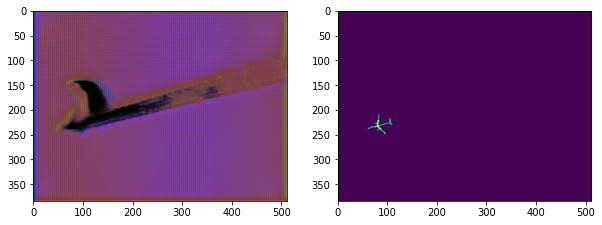

In [3]:
def load_data(path_root, path_list):
    path_list = [path_list] if type(path_list) == str else path_list
    return np.squeeze(np.array([np.load(os.path.join(path_root, i)) for i in path_list]))

temp_paths = os.listdir(train_x)
random.shuffle(temp_paths)
temp_paths = temp_paths[0]
sample_data = load_data(train_x, temp_paths)
sample_data_mask = load_data(train_y, temp_paths)

fig = plt.figure(figsize=(10,8))

fig.add_subplot(1,2,1)
plt.imshow(sample_data[:,:,6:9])
fig.add_subplot(1,2,2)
plt.imshow(sample_data_mask)

In [4]:
img_width, img_heigth, num_channels = sample_data.shape

## simple network1 - conv

In [5]:
def one_hot_channels(mask):
    flag = torch.from_numpy(mask).type(torch.bool)
    index_zero_hot = (torch.ones_like(flag).type(torch.FloatTensor) * ~flag)
    index_zero_hot.requires_grad = True
    index_one_hot = (torch.ones_like(flag).type(torch.FloatTensor) * flag)
    index_one_hot.requires_grad = True
    return index_zero_hot, index_one_hot

In [ ]:
seg_net = torch.nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=2, kernel_size=3,
                        stride=1, padding=1))
epochs = 5
bs = 10
learning_rate = 1e-3 
optimizer = torch.optim.Adam(seg_net.parameters(), lr=learning_rate)
losses = []
train_x_paths = os.listdir(train_x)
for i in range(epochs):
    random.shuffle(train_x_paths)
    batch_losses = []
    for j in range(len(train_x)//bs + 1):
        batch_paths = train_x_paths[i*bs: (i+1)*bs]
        batch_x = load_data(train_x, batch_paths)
        batch_x = torch.from_numpy(batch_x)
        batch_x = batch_x.permute((0, 3, 1, 2))
        batch_y = load_data(train_y, batch_paths)
        index_zero_hot, index_one_hot = one_hot_channels(batch_y, )
        pred_x = seg_net(batch_x)
        pred_x = torch.sigmoid(pred_x)
        loss = -pred_x[:, 1, :, :]*index_zero_hot - pred_x[:, 0, :, :]*index_one_hot
        loss = torch.mean(loss, dim=(0, 1, 2))
        batch_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = sum(batch_losses)
    losses.append(loss)
    print(f"epoch {i}, loss: {loss}")
    if i != epochs - 1:
        del loss
        del pred_x
        gc.collect()  

epoch 0, loss: -11.700054168701172
epoch 1, loss: -11.998648643493652
epoch 2, loss: -11.999069213867188
epoch 3, loss: -11.99820327758789


In [ ]:
plt.imshow(np.argmax(pred_x[2].detach().numpy(), 0), cmap="gray")

In [ ]:
plt.imshow(batch_y[2], cmap="gray")